# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 

Необходимо построить модель для определения стоимости. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.  

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb

Изучим предоставленные данные.

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Предобработка данных.

В данных присутствуют пропуски в следующих столбцах: `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`.

Наибольшее количество пропусков наблюдается в колонке `Repaired`. Удалив объекты с пропусками нам удастся сохранить менее 80% данных.

Можно пойти другим путем и заполнить пропуски исходя из наших предположений, так, например, в колонке `Repaired` объекты с пустыми значениями могут быть отмечены автомобили не подвергшиеся ремонту, однако такой подход довольно рискован.

Так как признаки с пропусками категориальные, заполним пустые значения заглушками.

In [5]:
df['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

В столбце с названиями моделей авто присутствует значение 'other', отнесем отсутствующие названия моделей к данной категории.

In [6]:
df = df.fillna({'Model': 'other'})

Пропуски данных в столбцах `Gearbox` и `Repaired` заполним новой категорией 'unknown':

In [7]:
df = df.fillna({'Gearbox': 'unknown', 'Repaired': 'unknown'})

Пропуски в столбцах `VehicleType` и `FuelType` заполним наиболее распространенными значениями для соответствующей модели автомобиля.

In [8]:
vehicle_type_of_models = df.groupby('Model')['VehicleType'].apply(list)

model_by_order = []
popular_vehicle_type_by_order = []
for i in vehicle_type_of_models.index:
    model_by_order.append(i)
    popular_vehicle_type_by_order.append(pd.Series(vehicle_type_of_models[i]).mode()[0])
    
popular_vehicle_type_for_each_model = dict(zip(model_by_order, popular_vehicle_type_by_order))

for model in model_by_order:
    df.loc[((df['VehicleType'].isna()) & (df['Model'] == model)), 'VehicleType'] = \
    df.loc[((df['VehicleType'].isna()) & (df['Model'] == model)), 'VehicleType'].fillna(popular_vehicle_type_for_each_model[model])

In [9]:
fuel_type_of_models = df.groupby('Model')['FuelType'].apply(list)

model_by_order = []
popular_fuel_type_by_order = []
for i in fuel_type_of_models.index:
    model_by_order.append(i)
    popular_fuel_type_by_order.append(pd.Series(fuel_type_of_models[i]).mode()[0])
    
popular_fuel_type_for_each_model = dict(zip(model_by_order, popular_fuel_type_by_order)) 

for model in model_by_order:
    df.loc[((df['FuelType'].isna()) & (df['Model'] == model)), 'FuelType'] = \
    df.loc[((df['FuelType'].isna()) & (df['Model'] == model)), 'FuelType'].fillna(popular_fuel_type_for_each_model[model])

-----

Проверим колонку `NumberOfPictures` на количество уникальных значений.

In [10]:
df['NumberOfPictures'].unique()

array([0])

Колонка неинформативна, избавимся от нее.

Некоторые колонки также бесполезны для построения модели, такие как: `DateCrawled`, `DateCreated`, `LastSeen`, `PostalCode`.

In [11]:
df = df.drop(['DateCrawled', 'NumberOfPictures', 'DateCreated', 'LastSeen', 'PostalCode'], axis='columns')

----

Проверим данные на наличие дубликатов.

In [12]:
df.duplicated().sum()

28755

В данных присутствуют дубликаты. Избавимся от них.

In [13]:
df = df.drop_duplicates()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325614 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              325614 non-null  int64 
 1   VehicleType        325614 non-null  object
 2   RegistrationYear   325614 non-null  int64 
 3   Gearbox            325614 non-null  object
 4   Power              325614 non-null  int64 
 5   Model              325614 non-null  object
 6   Kilometer          325614 non-null  int64 
 7   RegistrationMonth  325614 non-null  int64 
 8   FuelType           325614 non-null  object
 9   Brand              325614 non-null  object
 10  Repaired           325614 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.8+ MB


### Исследовательский анализ данных.

Проверим численные данные на наличие аномалий.

Рассмотрим колонку с ценами на автомобили.

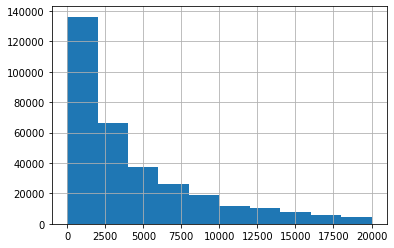

In [15]:
df['Price'].hist()
plt.show()

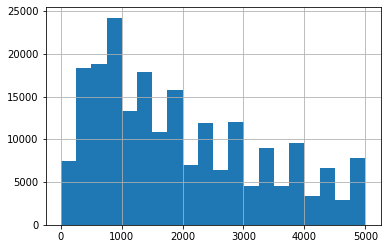

In [36]:
df['Price'].hist(range=(2, 5000), bins=20)
plt.show()

Удалим данные автомобилей с ценой меньше 100 евро.

In [28]:
df = df.loc[df['Price'] > 100] 

----

Рассмотрим колонку с годом регистрации автомобилей.

<AxesSubplot:>

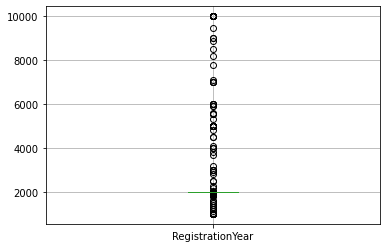

In [29]:
df.boxplot(column='RegistrationYear')

In [30]:
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 1958, 1967, 1956, 3200, 1000,
       1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940, 3000,
       2066, 1949, 2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234, 5300,
       9000, 2900, 6000, 5900, 5911, 1400, 5000, 1950, 4000, 1948, 1952,
       8500, 1932, 3700, 3800, 4800, 1942, 7000, 1935, 1933, 1936, 1923,
       2290, 1930, 1001, 9450, 1944, 2500, 1943, 1938, 1934, 1928, 5555,
       5600, 1600, 1111, 1039, 1300, 2800, 1931, 4500, 1602, 7800, 1947,
       1927, 7100, 8200, 1946])

<AxesSubplot:>

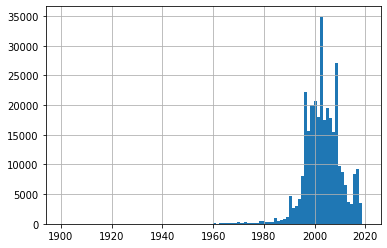

In [31]:
df['RegistrationYear'].hist(bins=100, range=(1900, 2020))

Избавимся от значений даты регистрации раньше 1960 года и позже 2020.

In [32]:
df = df.loc[((df['RegistrationYear'] >= 1960) & (df['RegistrationYear'] <= 2020))]

<AxesSubplot:>

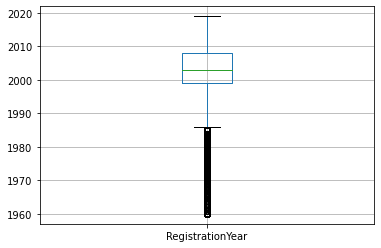

In [33]:
df.boxplot(column='RegistrationYear')

-----

Рассмотрим колонку с данными о мощности автомобилей.

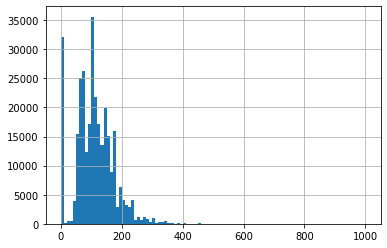

In [42]:
df['Power'].hist(bins=100, range=(0, 1000))
plt.show()

Избавимся от объектов с указанной мощностью меньше 30 и больше 600 л.с.

In [43]:
df = df.loc[((df['Power'] >= 30) & (df['Power'] <= 600))] 

-----

Рассмотрим колонку с пробегом.

<AxesSubplot:>

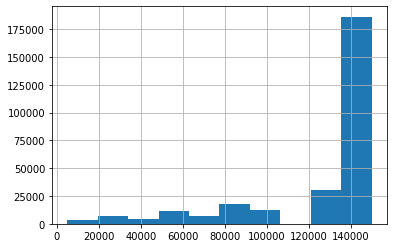

In [44]:
df['Kilometer'].hist()

В колонке с пробегом аномалий не обнаружено.

----

Рассмотрим колонку с указанием месяца регистрации авто.

<AxesSubplot:>

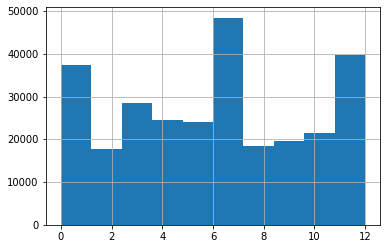

In [45]:
df['RegistrationMonth'].hist()

Аномалий не выявлено.

-----

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279617 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              279617 non-null  int64 
 1   VehicleType        279617 non-null  object
 2   RegistrationYear   279617 non-null  int64 
 3   Gearbox            279617 non-null  object
 4   Power              279617 non-null  int64 
 5   Model              279617 non-null  object
 6   Kilometer          279617 non-null  int64 
 7   RegistrationMonth  279617 non-null  int64 
 8   FuelType           279617 non-null  object
 9   Brand              279617 non-null  object
 10  Repaired           279617 non-null  object
dtypes: int64(5), object(6)
memory usage: 25.6+ MB


Таким образом, в ходе подготовки данных были выявлены и обработаны пропуски, удалены дубликаты. Также в данных были замечены аномальные значения некоторых признаков, объекты с такими признаки были также удалены.

## Обучение моделей

Закодируем категориальные признаки с помощью метода OHE. Это необходимо для построения модели линейной регрессии. 

In [48]:
df_ohe = pd.get_dummies(df, drop_first=True)

Для модели случайного леса используем порядковое кодирование.

In [49]:
enc = OrdinalEncoder()
enc.fit(df[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']])
df_ord = df.copy()
df_ord[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']] = enc.transform(df[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']])

Для модели LGBMRegressor нет необходимости кодировать категориальные признаки, необходимо только поменять тип с "object" на "category".

In [51]:
df_lgb = df.copy()
df_lgb[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']] = df[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']].astype('category')

Напишем функцию для получения обучающей и тестовой выборки для каждого типа кодирования категориальных признаков.

In [54]:
def get_samples(df):
    features = df.drop('Price', axis=1)
    target = df['Price']
    features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.25, 
                                                                            random_state=123)
    return features_train, features_test, target_train, target_test

In [56]:
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = get_samples(df_ohe)
features_train_ord, features_test_ord, target_train_ord, target_test_ord = get_samples(df_ord)
features_train_lgb, features_test_lgb, target_train_lgb, target_test_lgb = get_samples(df_lgb)

Так как модель будет оцениваться с помощью метрики RMSE, напишем отдельную функцию для данной метрики.

In [57]:
def rmse(target, predict):
    return mean_squared_error(target, predict, squared=False)
   
rmse_score = make_scorer(rmse, greater_is_better=False)

### Модель линейной регрессии.

In [63]:
%%time

lin_model = LinearRegression()

lin_grid = GridSearchCV(lin_model, {}, scoring=rmse_score, cv=3)
lin_grid.fit(features_train_ohe, target_train_ohe)
lin_model_score = lin_grid.score(features_train_ohe, target_train_ohe) * (-1)
print('Качество модели линейной регрессии:', lin_model_score)

# Качество модели линейной регрессии: 2649.667292001573
# CPU times: user 43.8 s, sys: 21.5 s, total: 1min 5s

Качество модели линейной регрессии: 2649.667292001573
CPU times: user 43.8 s, sys: 21.5 s, total: 1min 5s
Wall time: 1min 5s


### Модель случайного леса.

In [60]:
%%time

forest_model = RandomForestRegressor(n_estimators=30, random_state=123)

forest_parametrs = {'max_depth': range(1, 10, 2)}

forest_grid = GridSearchCV(forest_model, forest_parametrs, scoring=rmse_score, cv=3)
forest_grid.fit(features_train_ord, target_train_ord)
forest_model_score = forest_grid.score(features_train_ord, target_train_ord) * (-1)
print('Качество модели случайного леса:', forest_model_score)

# Качество модели случайного леса: 1903.320539110351
# CPU times: user 1min 5s, sys: 141 ms, total: 1min 5s

Качество модели случайного леса: 1903.320539110351
CPU times: user 1min 5s, sys: 141 ms, total: 1min 5s
Wall time: 1min 5s


### Модель LGBMRegressor

In [58]:
%%time

lgb_model = lgb.LGBMRegressor(random_state=123)

lgb_parametrs = {"n_estimators": [20, 50, 100],
               "num_leaves": [10, 30, 100]}

lgb_grid = GridSearchCV(lgb_model, lgb_parametrs, scoring=rmse_score, cv=3)
lgb_grid.fit(features_train_lgb, target_train_lgb)
lgb_model_score = lgb_grid.score(features_train_lgb, target_train_lgb) * (-1)
print('Качество модели LGBMRegressor:', lgb_model_score)

# Качество модели LGBMRegressor: 1448.460783068608
# CPU times: user 4min 55s, sys: 1.2 s, total: 4min 57s

Качество модели LGBMRegressor: 1448.460783068608
CPU times: user 4min 55s, sys: 1.2 s, total: 4min 57s
Wall time: 4min 59s


------

Таким образом наилучшей моделью оказалась модель основанная на алгоритме градиентного бустинга, со значением метрики rmse = 1625, что гораздо меньше rmse модели случайного леса (rmse = 1997) и модели линейной регрессии (rmse = 2736).

## Анализ моделей

Критерии, которые важны заказчику:
  * качество предсказания;
  * время обучения модели;
  * время предсказания модели.

Проведем анализ моделей на тестовой выборке и сравним время обучения и предсказания разных моделей.

### Модель линейной регрессии.

In [64]:
results = lin_grid.cv_results_
best_index = lin_grid.best_index_

lin_fit_time = results['mean_fit_time'][best_index]
lin_score_time = results['mean_score_time'][best_index]
lin_rmse = results['mean_test_score'][best_index] * -1

print(f"Fit time: {lin_fit_time}, Predict time: {lin_score_time}, Best RMSE: {lin_rmse}")

# Fit time: 14.0895889600118, Predict time: 0.3029905954996745, Best RMSE: 2655.0723923554947

Fit time: 14.0895889600118, Predict time: 0.3029905954996745, Best RMSE: 2655.0723923554947


### Модель случайного леса.

In [61]:
results = forest_grid.cv_results_
best_index = forest_grid.best_index_

forest_fit_time = results['mean_fit_time'][best_index]
forest_score_time = results['mean_score_time'][best_index]
forest_rmse = results['mean_test_score'][best_index] * -1

print(f"Fit time: {forest_fit_time}, Predict time: {forest_score_time}, Best RMSE: {forest_rmse}")

# Fit time: 6.1389938195546465, Predict time: 0.1725478172302246, Best RMSE: 1948.9230784686179

Fit time: 6.1389938195546465, Predict time: 0.1725478172302246, Best RMSE: 1948.9230784686179


### Модель LGBMRegressor.

In [59]:
results = lgb_grid.cv_results_
best_index = lgb_grid.best_index_

lgb_fit_time = results['mean_fit_time'][best_index]
lgb_score_time = results['mean_score_time'][best_index]
lgb_rmse = results['mean_test_score'][best_index] * -1

print(f"Fit time: {lgb_fit_time}, Predict time: {lgb_score_time}, Best RMSE: {lgb_rmse}")

# Fit time: 8.49432929356893, Predict time: 1.0690420468648274, Best RMSE: 1581.0366209733465x

Fit time: 8.49432929356893, Predict time: 1.0690420468648274, Best RMSE: 1581.0366209733465


### Сравнение результатов.

Сравним результаты обучения моделей.

In [65]:
result = pd.DataFrame(
    [
     [lin_rmse, lin_fit_time, lin_score_time], 
     [forest_rmse, forest_fit_time, forest_score_time], 
     [lgb_rmse, lgb_fit_time, lgb_score_time] ], 
    index=['LinearRegression', 'RandomForestRegressor', 'LightGBM'], 
    columns=['RMSE', 'fit_time', 'predict_time']
)
result

,RMSE,fit_time,score_time
LinearRegression,2655.072392,14.089589,0.302991
RandomForestRegressor,1948.923078,6.138994,0.172548
LightGBM,1581.036621,8.494329,1.069042


По качеству предсказаний модель основанная на градиентном бустинге значительно превосходит другие модели. Скорость обучения модели градиентного бустинга немного выше, чем у модели случайного леса, самое большое время при этом у модели линейной регресии. Время предсказания у модели градиентного бустинга больше чем у других моделей, однако в пределах одной секунды.

Проверим модель LGBMRegressor на тестовой выборке.

In [66]:
rmse(target_test_lgb, lgb_grid.predict(features_test_lgb))

1578.2050730520436

Значение метрики примерно соответствует ошибке на обучающей выборке.

## Вывод.

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов, в котором можно быстро узнать рыночную стоимость своего автомобиля. 

Нам были предоставленны данные: технические характеристики, комплектации и цены автомобилей, с помощью которых необходимо построить модель для определения стоимости.

В предоставленных данных присутствовали пропуски. Некоторые из пропусков были заполнены наиболее распространенными значениями для соответствующей модели автомобиля. Неинформативные колонки и дубликаты были удалены. Также в данных были обнаружены аномальные значения некоторых признаков. Объекты с такими признаками были также удалены.

Для разработки модели были рассмотрены следующие варианты:
* Модель линейной регрессии
* Модель случайного леса
* Модель LGBMRegressor

В качестве оценочной метрики была выбрана RMSE.

Наилучшей моделью оказалась модель основанная на алгоритме градиентного бустинга (LGBMRegressor), со значением метрики rmse = 1581, что гораздо меньше rmse модели случайного леса (rmse = 1948) и модели линейной регрессии (rmse = 2655). Время обучения модели градиентного бустинга при этом составило 8 мин, что гораздо меньше времени обучения модели алгоритма линейной регрессии (14 мин). Модель алгоритма случайного леса показала наименьшее время обучения (6 мин).

Время предсказания у модели градиентного бустинга немного выше чем у остальных моделей, однако остается в рамках одной секунды.

Для приложения рекомендуется применять модель на основе LGBMRegressor.